In [218]:
# Load modules for data manipulation
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import call
import pandas as pd
import numpy as np
import os

In [192]:
# Load modules for machine learning
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Calculate the accurancy of the model
from sklearn.metrics import accuracy_score, classification_report

# For drawing the graph
from sklearn.tree import export_graphviz

In [4]:
load_dotenv()

True

In [10]:
# clt = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'TJ38.csv', encoding='ISO-8859-1', sep='\t')
clt = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'TR35.csv', encoding='ISO-8859-1', sep='\t', low_memory=False)
ctr = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'TJ7S.csv', encoding='ISO-8859-1', sep='\t', usecols=['COCO', 'COMAX', 'COPRO'], low_memory=False)

eco = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'eco-products.csv', encoding='ISO-8859-1', sep='\t')

## Get the best ecological product

In [11]:
# Get the list of all the eco products code
eco = [str(i).zfill(5) for i in eco['COPRO']]

# ECO: 00003 | 242568 - LIVRET DEVELOPPEMENT DURABLE ET SOLIDAIRE
# DEPOTS MONETAIRES - EPARGNE MONETAIRE LIQUIDE - LIVRETS REGLEMENTES
# ctr[ctr['COPRO'].isin(eco)]['COPRO'].value_counts()

## Concatinate with other tables TJ39 - TJDR - TJER

In [16]:
tj39 = pd.read_csv(os.getenv('DATA_PATH') + '/' + 'tj39.csv', encoding='ISO-8859-1', sep=';', usecols=['COMAX', 'MSMENC', 'MTPATR', 'MTVAOP'])
tjdr = pd.read_csv(os.getenv('DATA_PATH') + '/' + 'tjdr.csv', encoding='ISO-8859-1', sep=';', usecols=['COMAX', 'MTRVIM', 'MTRVFR', 'QTPAFI', 'COHAVI'])
tjer = pd.read_csv(os.getenv('DATA_PATH') + '/' + 'tjer.csv', encoding='ISO-8859-1', sep=';', usecols=['COMAX', 'MTAPJE', 'MTPJE'])

In [17]:
# pour le cas de la table tj39, la variable COMAX elle est de 13 caracteres
# or celle des autres tables sont de 10, donc il fallait convertir de 13 a 10
# on prend les 10 premiers caractères du COMAX de tj39, d'apres le data engineer
# de la PBS.
tj39['COMAX'] = [val[:10] for val in tj39['COMAX'].values]

In [158]:
# This table is only good fot the moral clients only
data = pd.merge(clt,tj39,on='COMAX',how='left')
data = pd.merge(data,tjer,on='COMAX',how='left')
data = pd.merge(data,tjdr,on='COMAX',how='left')

In [159]:
data.shape

(1689052, 120)

In [160]:
data = data.drop_duplicates(subset="COMAX")

In [161]:
data['CTSCPI'] = data['CTSCPI'].astype(str)
data['COPOST'] = data['COPOST'].astype(str)

data['COPOST'].replace('nan', np.nan, inplace=True)
data['CTSCPI'].replace('nan', np.nan, inplace=True)

data.dropna(subset=['COPOST'], inplace=True)
data.dropna(subset=['CTSCPI'], inplace=True)

In [162]:
# replace Male with 0, et F avec 1
data['COSEXE'].replace('M', 0, inplace=True)
data['COSEXE'].replace('F', 1, inplace=True)

In [163]:
# get the ids of the products
ids = ctr[ctr['COPRO'].isin(eco)]['COMAX'].values
data['ECO'] = data['COMAX'].isin(ids)

In [164]:
# these values are based int but detected as object
why = ['CTCOPO', 'CTMENB', 'CTSIFA', 'COPOAG', 'CTSC90', 'CTSC91', 'CTSC92', 'CTFORT','PSGPAR',
'CEBPF1', 'CEBPF2', 'CEBPF3', 'CEBPF4', 'CEBPF5', 'CEBPF6', 'CEBPF7', 'CTBP']

for i in why:
    for k in [j for j in data[i].unique() if j.strip() == '']:
         data[i].replace(k, np.nan, inplace=True)

In [165]:
to_del = ['COPOST', 'COGRRB', 'COESPF']
cols = list(data.columns.values[1:-1])

for i in to_del:
    cols.remove(i)

for l in cols:
    try:
        data[l] = data[l].fillna(data[l].median())
    except:
        cols.remove(l)

In [194]:
len(cols)

113

In [184]:
%store data
%store cols
%store eco

Stored 'data' (DataFrame)
Stored 'cols' (list)
Stored 'eco' (list)


In [201]:
def random_forest(data, ecos, cols):   
    ''' The Model'''
    
    # Labels are the values we want to predict
    labels = np.array(data['ECO'])

    # Remove the labels from the features
    features = np.array(data[cols])

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state=42)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # Classification report
    print(classification_report(test_labels, predictions.round()))    

In [202]:
def knn(data, ecos, cols):
    ''' The Model'''
    
    # Labels are the values we want to predict
    labels = np.array(data['ECO'])

    # Remove the labels from the features
    features = np.array(data[cols])

    # Split the data into training and testing sets, random_state = 42
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state=42)

    # Instantiate model with 1000 decision trees
    model = KNeighborsClassifier(n_neighbors=3)
    
    # Train the model on training data
    model.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = model.predict(test_features)

    # Classification report
    print(classification_report(test_labels, predictions.round()))

In [203]:
def log_reg(data, ecos, cols):
    ''' The Model'''
    
    # Labels are the values we want to predict
    labels = np.array(data['ECO'])

    # Remove the labels from the features
    features = np.array(data[cols])

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state=42)

    # Instantiate model with 1000 decision trees
    logisticRegr = LogisticRegression()
    
    # Train the model on training data
    logisticRegr.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = logisticRegr.predict(test_features)

    # Classification report
    print(classification_report(test_labels, predictions.round()))

In [179]:
''' The Model'''

# Labels are the values we want to predict
labels = np.array(data['ECO'])

# Remove the labels from the features
features = np.array(data[cols])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [180]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Classification report
print(classification_report(test_labels, predictions.round()))

MODEL:: 7835.810256719589
MODEL:: 7861.329950809479
              precision    recall  f1-score   support

       False       0.90      0.99      0.95     69151
        True       0.99      0.77      0.87     32128

    accuracy                           0.92    101279
   macro avg       0.94      0.88      0.91    101279
weighted avg       0.93      0.92      0.92    101279



# - - - - - - - -- - - - - - - - - - - - - - - - -- - - - - - 

In [234]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature name logistic regressions
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    plt.savefig('{}.svg'.format(model_type))

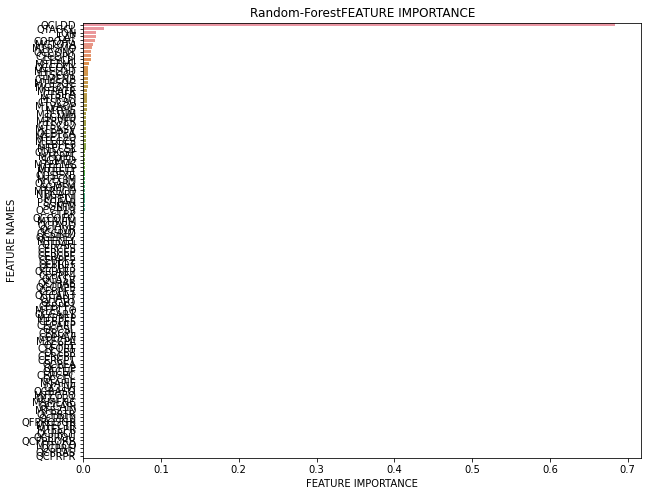

In [235]:
plot_feature_importance(rf.feature_importances_,cols,'Random-Forest')

In [227]:
for lol in sorted(zip(cols, rf.feature_importances_), key=lambda x: x[1], reverse=True):
    print(lol)

('QCLDD', 0.6830778681301825)
('QTAGCL', 0.027285303047317317)
('LON', 0.016697951472147785)
('LAT', 0.016047415292769894)
('COPOAG', 0.014686379348962008)
('MCTOTA', 0.01284497624851695)
('MTRSMO', 0.011636637553439418)
('QCCONT', 0.010622253328147742)
('CTCOPO', 0.01018126404418302)
('CTSCPI', 0.00980175538372276)
('MTEEML', 0.007713479324890817)
('QCCOCY', 0.006791271357492967)
('MTELDD', 0.006588952175419229)
('CTSC91', 0.006118154205888067)
('CTMENB', 0.005969082222298445)
('MTESOC', 0.005694505623322762)
('MCTOTE', 0.005630264625372224)
('MTPATR', 0.005413372931056585)
('CTSIFA', 0.005263744897834841)
('MTRSFI', 0.005250065062479204)
('CTSC90', 0.005063761968687887)
('MTVAOP', 0.004769276937980766)
('MTPJE', 0.00456903457613818)
('MTCDIM', 0.004145836185448564)
('SGMID', 0.004036984545802437)
('MTRVFR', 0.00390761696705884)
('CTSC92', 0.0038700945575680353)
('MTEASV', 0.00362191273979882)
('QCBPFA', 0.003518184844372426)
('MTE19D', 0.0033726765302844763)
('MTECCS', 0.003230559944

In [28]:
matrix = data.corr().values

In [35]:
for i in range(len(cols) - 1):
    for j in range(i+1, len(cols)):
        print('{} -- {}:: {}'.format(cols[i], cols[j], matrix[i][j]*100))

CTSCPI -- CODCSP:: 5.729616389801779
CTSCPI -- COSEXE:: -20.780067899011932
CTSCPI -- QTAGCL:: -29.37657658692635
CTSCPI -- NBCART:: -15.350761871328569
CTSCPI -- QCLDD:: -5.726346893486517
CTSCPI -- QCCEL:: -4.363044789356529
CTSCPI -- QCPEL:: -0.3455464008840324
CTSCPI -- QCPEP:: 9.193486026171135
CTSCPI -- QCCSL:: 23.348734868179903
CTSCPI -- QCLIVJ:: -1.7528288524597626
CTSCPI -- QCLEP:: -31.494578786063794
CTSCPI -- QCCP19:: -0.6098451152218634
CTSCPI -- QCCP21:: -7.793716189848941
CTSCPI -- QCIHAB:: -5.5111267554148755
CTSCPI -- QTIAUT:: -9.094906284930081
CTSCPI -- QCITOT:: -4.741515572235222
CTSCPI -- QCASV:: 2.6598017657981137
CTSCPI -- QCLIVR:: -2.599635869858459
CTSCPI -- QCCTO:: -3.331525391732558
CTSCPI -- QCPEA:: -27.62013816878684
CTSCPI -- QCCRIM:: -16.138263668839183
CTSCPI -- QCCRPE:: 8.863420061538022
CTSCPI -- QCCAR1:: -15.64190481878189
CTSCPI -- QCCAR2:: -20.165486103489076
CTSCPI -- QCCAR3:: -18.991026861792925
CTSCPI -- QCCARP:: -5.162674078864918
CTSCPI -- QCCA

MTECTR -- MTEEMC:: 22.304725488121953
MTECTR -- MTESOC:: 46.674415744199536
MTECTR -- MCTOTA:: -3.458764135467602
MTECTR -- MCTOTE:: 3.7366711850020744
MTECTR -- QCCOCY:: -27.820329511981694
MTECTR -- QTCLIF:: 21.331790704413002
MTECTR -- SGMFM:: 18.03944737026655
MTECTR -- SGMFD:: 22.334437959865443
MTECTR -- SGMIM:: 18.58386241586899
MTECTR -- SGMID:: 1.3415240912076234
MTECTR -- CERCPT:: 5.950780422936521
MTECTR -- CERCPE:: 5.639971918434785
MTECTR -- CERCEP:: 5.80622483678523
MTECTR -- CERCPS:: 1.4478344272436536
MTECTR -- CERCPL:: 1.0215519721814867
MTECTR -- CERCPC:: 0.8243125835119361
MTECTR -- CERCPP:: 14.802696359833176
MTECTR -- QCBPFA:: -1.9957831888724311
MTECTR -- QCPREV:: 1.5693573854424652
MTECTR -- QCIARD:: -0.04310404665487836
MTECTR -- MTFLPR:: -5.30576074750778e-11
MTECTR -- MTFLCO:: 14.983950490434234
MTECTR -- MTRSFI:: 67.62053033145786
MTECTR -- MTRSMO:: 0.09635227248511434
MTECTR -- QCFPRORB:: 0.13445368924255802
MTECTR -- QFPROSGR:: -0.40900271346524114
MTECTR -